Курсовой проект студента группы М8О-406Б-18 Кузьмичева Александра

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
%matplotlib inline

## Данные

Данные содержат взятые измерения банкнот с картинок и класс, которому они 
относятся: подлинные или нет.

Столбец | Описание
:-----: | :------
0       | Среднеквадратическое отклонение вейвлет-преобразованой картинки
1       | Ассиметрия вейвлет-преобразованой картинки
2       | Коэффициент эксцесса вейвлет-преобразованой картинки
3       | Энтропия картинки
4       | Класс (0 - подлинная, 1 - нет)

In [3]:
csv_path = '/content/drive/My Drive/data_banknote_authentication.csv'
notes = pd.read_csv(csv_path, header=None)
notes.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Размер данных и проверка на наличие пустых элементов:

In [4]:
print("Dataframe shape:", notes.shape)
notes.isnull().sum()

Dataframe shape: (1372, 5)


0    0
1    0
2    0
3    0
4    0
dtype: int64

Рассмотрим корреляцию между особенностями:

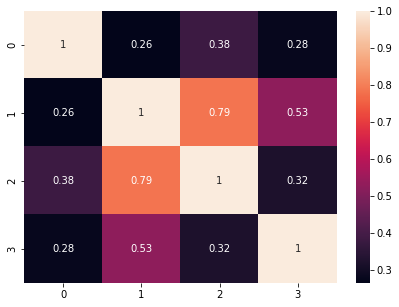

In [5]:
plt.subplots(figsize=(7, 5))
notes_corr = notes.iloc[:, :-1].corr().abs()
sns.heatmap(notes_corr, annot=True)

На графике видно, первый столбец имеет высокую коррелиацию с двумя другими, 
поэтому исключим его:

In [6]:
notes = notes.drop(
    columns=notes.columns[1], axis=1
)

При обучении будут использоваться стандартные метрики:
* **Precision** (точность) - количество правильно классифицированных 
  положительных предметов из выбранных для классификации:
  $$
    precision = \frac{TP}{TP + FP}
  $$
* **Recall** (полнота) - количество правильно классифицированных 
  положительных предметов из всех возможных
  (т.е. множество правильно и неправильно классифицированных предметов):
  $$
    recall = \frac{TP}{TP + FN}
  $$

$TP$ - количество корректно классифицированных положительных предметов,
$FP$ - количество некорректно классифицированных отрицательных предметов,
$TP$ - количество некорректно классифицированных положительных предметов.

Можно также использовать **accuracy** (количество правильно классифицированных
предметов из всех доступных), но её точность малозначима, так как классов 
неравное количество.

In [7]:
def precision(pred, real):
    matrix = np.zeros((2, 2))
    for y, p in zip(pred, real):
        matrix[1 - y, 1 - p] += 1
    
    if matrix[0, 0] + matrix[1, 0] == 0:
        return 0
    return matrix[0, 0] / (matrix[0, 0] + matrix[1, 0])

def recall(pred, real):
    matrix = np.zeros((2, 2))
    for y, p in zip(pred, real):
        matrix[1 - y, 1 - p] += 1
    
    if matrix[0, 0] + matrix[0, 1] == 0:
        return 0
    return matrix[0, 0] / (matrix[0, 0] + matrix[0, 1])

## Модель

Модель - логистическая регрессия и **L2** ругляризацией.

In [20]:
import numpy as np

class LogisticRegression:
    def __init__(self, *, reg_param=1.0, lr=0.01, max_iter=100):
        self._a  = reg_param
        self._lr = lr
        self._max_iter = max_iter
        self._feat_count = 0
        self._weights = None
        self._bias = 0

    def fit(self, feats, labels):
        if self._weights is None:
            self._feat_count = feats.shape[1]
            self._weights = np.zeros(self._feat_count)
        elif self._feat_count != feats.shape[1]:
            err = f"Feature count does not match previous count {self._feat_count}"
            raise ValueError(err)

        costs      = np.zeros((self._max_iter))
        precisions = np.zeros((self._max_iter))
        recalls    = np.zeros((self._max_iter))

        for i in range(self._max_iter):
            pred = self._predict(feats)

            costs[i] = self._cost(pred, labels)
            precisions[i] = precision(pred.round().astype(int), labels)
            recalls[i] = recall(pred.round().astype(int), labels)

            sample_count = len(labels)
            norm_coef = self._a
            coef = np.mean(pred - labels)

            dw = np.dot(feats.T, pred - labels) / sample_count + norm_coef * self._weights
            db = coef + norm_coef * self._bias

            self._weights -= dw * self._lr
            self._bias    -= db * self._lr
        
        return {
            "cost": costs,
            "precision": precisions,
            "recall": recalls,
            "max_iter": self._max_iter,
        }

    def predict(self, X):
        return self._predict(X).round()

    def _predict(self, feats):
        weights = self._weights
        bias    = self._bias
        return 1 / (1 + np.exp(-( np.dot(feats, weights) + bias)))
    
    def _cost(self, preds, labels):
        return -1 * np.mean( 
            np.multiply(labels, np.log(preds)) \
            + np.multiply(1 - labels, np.log(1 - preds))
        )        

## Обучение

Маштабирование данных и дальнейшее разделение на обучающее и тестовое множества:

In [21]:
from sklearn.model_selection import train_test_split


X = notes.iloc[:, :-1]
y = notes.iloc[:, -1]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    ss.fit_transform(X), y, 
    test_size=0.3, random_state=10
)

Само обучение модели:

Final precision: 0.7903225806451613
Final recall: 0.8258426966292135


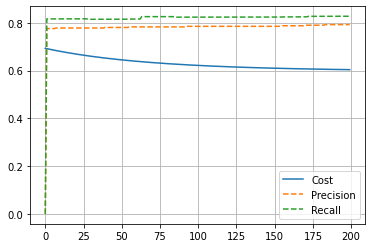

In [36]:
custom_model = LogisticRegression(max_iter=200, reg_param = 1)
graphs = custom_model.fit(X_train, y_train)

plt.plot(graphs["cost"],                      label="Cost")
plt.plot(graphs["precision"], linestyle='--', label="Precision")
plt.plot(graphs["recall"],    linestyle='--', label="Recall")
plt.grid()
plt.legend()

preds = custom_model.predict(X_test).astype(int)

print("Final precision:", precision(preds, y_test))
print("Final recall:", recall(preds, y_test))

Обучение с sklearn:

In [ ]:
from sklearn import linear_model

sklearn_model = linear_model.LogisticRegression()

sklearn_model.fit(X_train, y_train)

preds = sklearn_model.predict(X_test).astype(int)

print("Final precision:", precision(preds, y_test))
print("Final recall:", recall(preds, y_test))

Final precision: 0.9354838709677419
Final recall: 0.9015544041450777


Попробуем оптимизировать алгоритм, убрав L2 нормализацию. Для этого обнулим параметр reg_param.

Final precision: 0.7903225806451613
Final recall: 0.8305084745762712


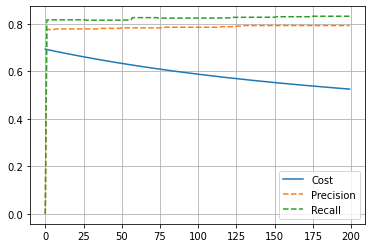

In [38]:
custom_model = LogisticRegression(max_iter=200, reg_param = 0)
graphs = custom_model.fit(X_train, y_train)

plt.plot(graphs["cost"],                      label="Cost")
plt.plot(graphs["precision"], linestyle='--', label="Precision")
plt.plot(graphs["recall"],    linestyle='--', label="Recall")
plt.grid()
plt.legend()

preds = custom_model.predict(X_test).astype(int)

print("Final precision:", precision(preds, y_test))
print("Final recall:", recall(preds, y_test))